# Skin cancer detection with SHAP and LIME

## Loading and Preprocessing Data

### Main points:

1. **Import Libraries**: Imports necessary libraries such as `pandas`, `numpy`, `tensorflow`, and `sklearn` for data manipulation and model building.

2. **Set Paths**: 
   - `IMAGE_DIR`: Directory where images are stored.
   - `METADATA_CSV`: Path to the CSV file with image metadata.

3. **Load Metadata**: 
   - Reads metadata from the CSV file into a DataFrame (`df`).
   - Maps diagnosis labels to numeric values using `label_map`.

4. **Load and Preprocess Images**: 
   - `load_images` function loads images, resizes them, and applies preprocessing for EfficientNetB0.
   - Converts images to arrays and labels to integers.

5. **Train/Test Split**: 
   - Uses `train_test_split` to divide the data into training and testing sets (80/20 split).

6. **Save Label Map**: 
   - Saves the `label_map` to a file for future use in model predictions.

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Paths to data
IMAGE_DIR = 'HAM10000_images' 
METADATA_CSV = 'HAM10000_metadata.csv'

# Loading metadata
df = pd.read_csv(METADATA_CSV)

# Mapping diagnoses to numbers
label_map = {label: idx for idx, label in enumerate(df['dx'].unique())}
df['label'] = df['dx'].map(label_map)

# Loading images function
def load_images(df, image_dir, target_size=(224, 224)):
    """
    Load images and preprocess them.
    
    Args:
        df: DataFrame containing metadata with image file names and labels.
        image_dir: Directory where the images are stored.
        target_size: Target image size after resizing.
        
    Returns:
        images: Array of preprocessed images.
        labels: Array of labels corresponding to the images.
    """
    images, labels = [], []
    missing = 0
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['image_id'] + '.jpg')
        if os.path.exists(image_path):
            img = load_img(image_path, target_size=target_size)
            img = img_to_array(img)
            # Preprocessing for EfficientNetB0
            img = preprocess_input(img)
            images.append(img)
            labels.append(row['label'])
        else:
            missing += 1
    print(f"Number of missing images: {missing}")
    return np.array(images), np.array(labels)

# Loading images and labels
images, labels = load_images(df, IMAGE_DIR)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Saving label map for later use
np.save('label_map.npy', label_map)

## Model Training or Fine-Tuning EfficientNetB0

### Main points:

1. **Image Augmentation**: 
   - Uses `ImageDataGenerator` to apply various transformations like flipping, rotation, zoom, and brightness adjustments to increase training data diversity.

2. **EfficientNetB0 Base Model**: 
   - Loads EfficientNetB0 without the top layer (`include_top=False`), keeping the pre-trained weights from ImageNet.
   
3. **Freezing Layers**: 
   - Freezes all but the last 100 layers of the base model, allowing only the final layers to be fine-tuned during training.

4. **Custom Classifier**: 
   - Adds a custom classifier consisting of `GlobalAveragePooling2D`, `BatchNormalization`, `Dropout`, and a `Dense` output layer with a softmax activation.

5. **Model Compilation**: 
   - Compiles the model with the Adam optimizer, sparse categorical cross-entropy loss, and accuracy as the metric.

6. **Callbacks**: 
   - Uses `ModelCheckpoint` to save the best model based on validation accuracy and `EarlyStopping` to halt training early if validation loss doesn’t improve.

7. **Model Training**: 
   - Trains the model using the augmented training data, with validation on the test set for 25 epochs.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Image augmentation for training
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=10,
    brightness_range=[0.8, 1.2]
)
datagen.fit(X_train)

# EfficientNetB0 base model without the top classification layer
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

# Freezing most layers and fine-tuning the last 100 layers
for layer in base_model.layers[:-100]:
    layer.trainable = False
for layer in base_model.layers[-100:]:
    layer.trainable = True

# Adding a custom classifier on top of EfficientNetB0
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(len(np.unique(y_train)), activation='softmax', kernel_regularizer=l2(0.001))(x)
model = Model(inputs=base_model.input, outputs=output)

# Compiling the model
model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Checkpoint for best model and early stopping to avoid overfitting
checkpoint = ModelCheckpoint("efficientnet_advanced.h5", monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Training the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/25
251/251 [==============================] - ETA: 0s - loss: 1.6906 - accuracy: 0.5298

c:\Users\Elina\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


251/251 [==============================] - 394s 2s/step - loss: 1.6906 - accuracy: 0.5298 - val_loss: 1.0286 - val_accuracy: 0.7179
Epoch 2/25
251/251 [==============================] - 385s 2s/step - loss: 1.0444 - accuracy: 0.7244 - val_loss: 0.8688 - val_accuracy: 0.7644
Epoch 3/25
251/251 [==============================] - 386s 2s/step - loss: 0.8719 - accuracy: 0.7592 - val_loss: 0.9106 - val_accuracy: 0.7678
Epoch 4/25
251/251 [==============================] - 387s 2s/step - loss: 0.7419 - accuracy: 0.7862 - val_loss: 0.7117 - val_accuracy: 0.7958
Epoch 5/25
251/251 [==============================] - 388s 2s/step - loss: 0.6357 - accuracy: 0.8069 - val_loss: 0.6864 - val_accuracy: 0.8048
Epoch 6/25
251/251 [==============================] - 391s 2s/step - loss: 0.5760 - accuracy: 0.8191 - val_loss: 0.6565 - val_accuracy: 0.8088
Epoch 7/25
251/251 [==============================] - 387s 2s/step - loss: 0.5256 - accuracy: 0.8352 - val_loss: 0.6276 - val_accuracy: 0.8243
Epoch 8/25

In [ ]:
model.save("efficientnet_advanced.h5")

## Manual SHAP Implementation for Image Explanations

### Main points:

1. **SHAP Calculation with Superpixels**:
   - **`compute_shap_with_superpixels_stable`** computes SHAP values by perturbing superpixels of an image and comparing the model's output. 
   - It divides the image into superpixels using the `slic` algorithm and calculates how each superpixel influences the model's prediction.

2. **Top-k Superpixels Based on Importance**:
   - **`top_k_segments_near_center`** identifies the most important superpixels based on SHAP values and selects those closest to the image's center. 
   - It uses the SHAP values to prioritize segments that most affect the prediction and filters based on proximity to the image center.

3. **SHAP Visualization with Spatial Filtering**:
   - **`compare_original_and_shap_spatial`** visualizes the original image and SHAP explanation side by side.
   - It shows the superpixels that have the highest SHAP values, providing insight into which parts of the image the model focuses on.

4. **Image Normalization for Display**:
   - **`normalize_for_display`** normalizes images to a range suitable for display, ensuring that pixel values are between 0 and 255.

5. **Example**:
   - An example test image is processed to compute SHAP values, and the results are visualized, showing the impact of each superpixel on the model's prediction.


1/1 [==============================] - 0s 224ms/step


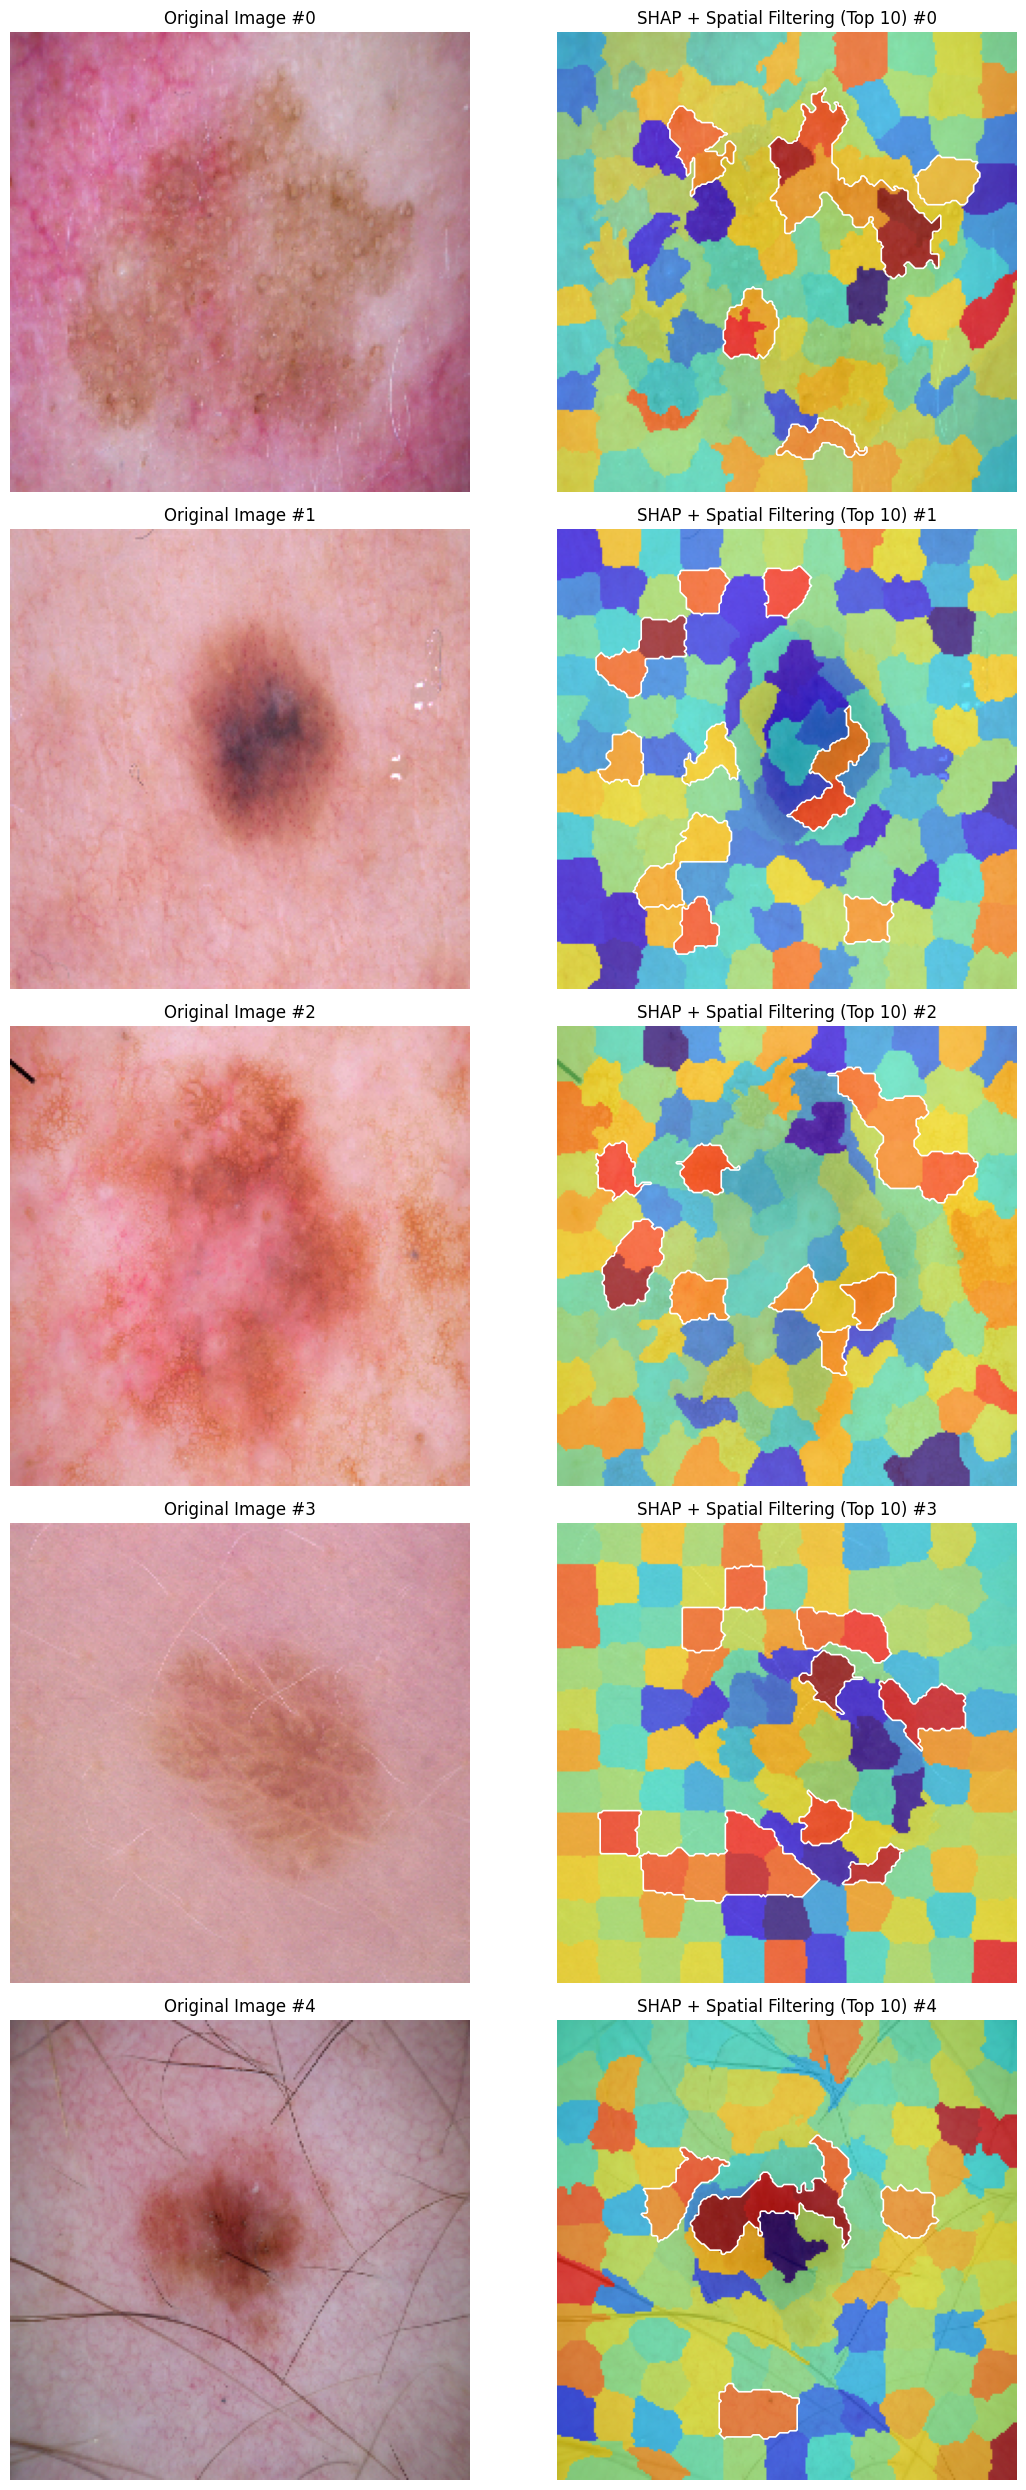

In [ ]:
from tensorflow.keras.models import load_model
from skimage.segmentation import slic
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import median_filter

# Model loading
model = load_model("efficientnet_advanced.h5")

# SHAP Calculation with Superpixels
def compute_shap_with_superpixels_stable(model, image, background, num_samples=500, n_segments=120):
    """
    Compute SHAP values using superpixels and a model.
    
    Args:
        model: The trained model to explain.
        image: Input image to explain.
        background: A set of background images for comparison.
        num_samples: Number of samples for Monte Carlo estimation.
        n_segments: Number of superpixels.
        
    Returns:
        shap_values: SHAP values corresponding to each pixel.
        segments: Superpixel segments of the image.
    """
    segments = slic(image, n_segments=n_segments, compactness=10, sigma=1, start_label=0)
    shap_values = np.zeros_like(image)
    original_pred = model.predict(image[np.newaxis, ...])[0]
    target_class = np.argmax(original_pred)
    background_mean = np.mean(background, axis=0)

    for _ in range(num_samples):
        seg_ids = np.unique(segments)
        included_segments = np.random.choice(seg_ids, size=len(seg_ids) // 2, replace=False)

        mask = np.isin(segments, included_segments).astype(np.float32)
        mask = np.expand_dims(mask, axis=-1)
        mask = np.repeat(mask, 3, axis=-1)

        perturbed = image * mask + background_mean * (1 - mask)
        pred = model.predict(perturbed[np.newaxis, ...])[0]
        shap_values += (pred[target_class] - original_pred[target_class]) * mask

    shap_values /= num_samples
    return shap_values, segments

# Top-k Superpixels Based on Importance and Spatial Filtering
def top_k_segments_near_center(shap_vals, segments, k=10, max_dist_frac=0.3):
    """
    Filter top-k superpixels close to the center of the image based on SHAP values.
    
    Args:
        shap_vals: SHAP values for each pixel.
        segments: Segmented superpixels.
        k: Number of top segments to keep.
        max_dist_frac: Fraction of maximum distance allowed from the center.
        
    Returns:
        A binary mask for top-k segments.
    """
    attribution = np.mean(np.abs(shap_vals), axis=-1)
    attribution = median_filter(attribution, size=3)

    segment_scores = {}
    centroids = {}

    for seg_id in np.unique(segments):
        mask = (segments == seg_id)
        score = np.mean(attribution[mask])
        ys, xs = np.where(mask)
        centroids[seg_id] = (np.mean(xs), np.mean(ys))
        segment_scores[seg_id] = score

    # Compute the center of mass
    yx_weights = np.array(np.nonzero(attribution)).T
    values = attribution[attribution > 0]
    center = np.average(yx_weights, axis=0, weights=values)

    # Select top-k segments based on score and proximity to the center
    top_segments = sorted(segment_scores.items(), key=lambda x: x[1], reverse=True)[:k*2]

    # Remove segments that are too far from the center
    H, W = attribution.shape
    keep = []
    for seg_id, score in top_segments:
        cx, cy = centroids[seg_id]
        dist = np.linalg.norm(np.array([cy, cx]) - center)
        if dist < max_dist_frac * np.sqrt(H**2 + W**2):
            keep.append(seg_id)

    return np.isin(segments, keep)

# Normalization for Display
def normalize_for_display(img):
    """
    Normalize the image for display purposes (between 0 and 255).
    
    Args:
        img: Image to normalize.
        
    Returns:
        Normalized image.
    """
    img = np.copy(img)
    if img.max() <= 1.0 and img.min() >= -1.0:
        img = ((img + 1.0) * 127.5)
    return np.clip(img, 0, 255).astype(np.uint8)

# Visualization of SHAP with Spatial Filtering
def compare_original_and_shap_spatial(image, shap_vals, segments, k=10):
    """
    Compare the original image and SHAP visualization with spatial filtering.
    
    Args:
        image: Original image.
        shap_vals: SHAP values for each pixel.
        segments: Superpixel segments.
        k: Number of top segments to highlight.
    """
    attribution = np.mean(np.abs(shap_vals), axis=-1)
    attribution = median_filter(attribution, size=3)
    mask_topk = top_k_segments_near_center(shap_vals, segments, k=k)

    # Plotting original and SHAP visualizations
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image.astype(np.uint8))
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(image.astype(np.uint8))
    axs[1].imshow(attribution, cmap='jet', alpha=0.6)
    axs[1].contour(mask_topk, colors='white', linewidths=1.2)
    axs[1].set_title(f"SHAP + Spatial Filtering (Top {k})")
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()

# Example - Running SHAP for 5 Test Images
fig, axs = plt.subplots(5, 2, figsize=(12, 25))

for idx in range(5):
    test_image = X_test[idx]
    test_label = y_test[idx]
    background = X_train[y_train == test_label][:50]

    shap_result, segs = compute_shap_with_superpixels_stable(model, test_image, background)
    norm_img = normalize_for_display(test_image)

    attribution = np.mean(np.abs(shap_result), axis=-1)
    attribution = median_filter(attribution, size=3)
    mask_topk = top_k_segments_near_center(shap_result, segs, k=10)

    axs[idx, 0].imshow(norm_img)
    axs[idx, 0].set_title(f"Original Image #{idx}")
    axs[idx, 0].axis('off')

    axs[idx, 1].imshow(norm_img)
    axs[idx, 1].imshow(attribution, cmap='jet', alpha=0.6)
    axs[idx, 1].contour(mask_topk, colors='white', linewidths=1.2)
    axs[idx, 1].set_title(f"SHAP + Spatial Filtering (Top 10) #{idx}")
    axs[idx, 1].axis('off')

plt.tight_layout()
plt.show()

## Manual LIME Implementation for Image Explanations

### Main points:

1. **LIME Normalization**:
   - **`normalize_for_lime`** normalizes the image to a range suitable for LIME (between 0 and 255).

2. **Image Segmentation**:
   - **`segment_image`** segments the image into superpixels using the SLIC algorithm, making the image easier to perturb and interpret.

3. **Generating a LIME Dataset**:
   - **`generate_lime_dataset`** creates a dataset of perturbed images, where each superpixel is randomly hidden (masked), and the model's prediction is recorded. This allows LIME to evaluate the impact of each superpixel on the prediction.

4. **Fitting a Local Model**:
   - **`fit_local_model`** fits a Ridge regression model to the perturbed images (from the previous step). It uses the perturbation masks as features and the model's predictions as target values. This helps in understanding which superpixels are most important for the model's prediction.

5. **Example**:
   - An example test image is processed, and the LIME explanation is visualized.

This implementation provides a way to visually explain a model's prediction by showing which parts of an image are most influential, using LIME to highlight key superpixels.


1/1 [==============================] - 0s 488ms/step


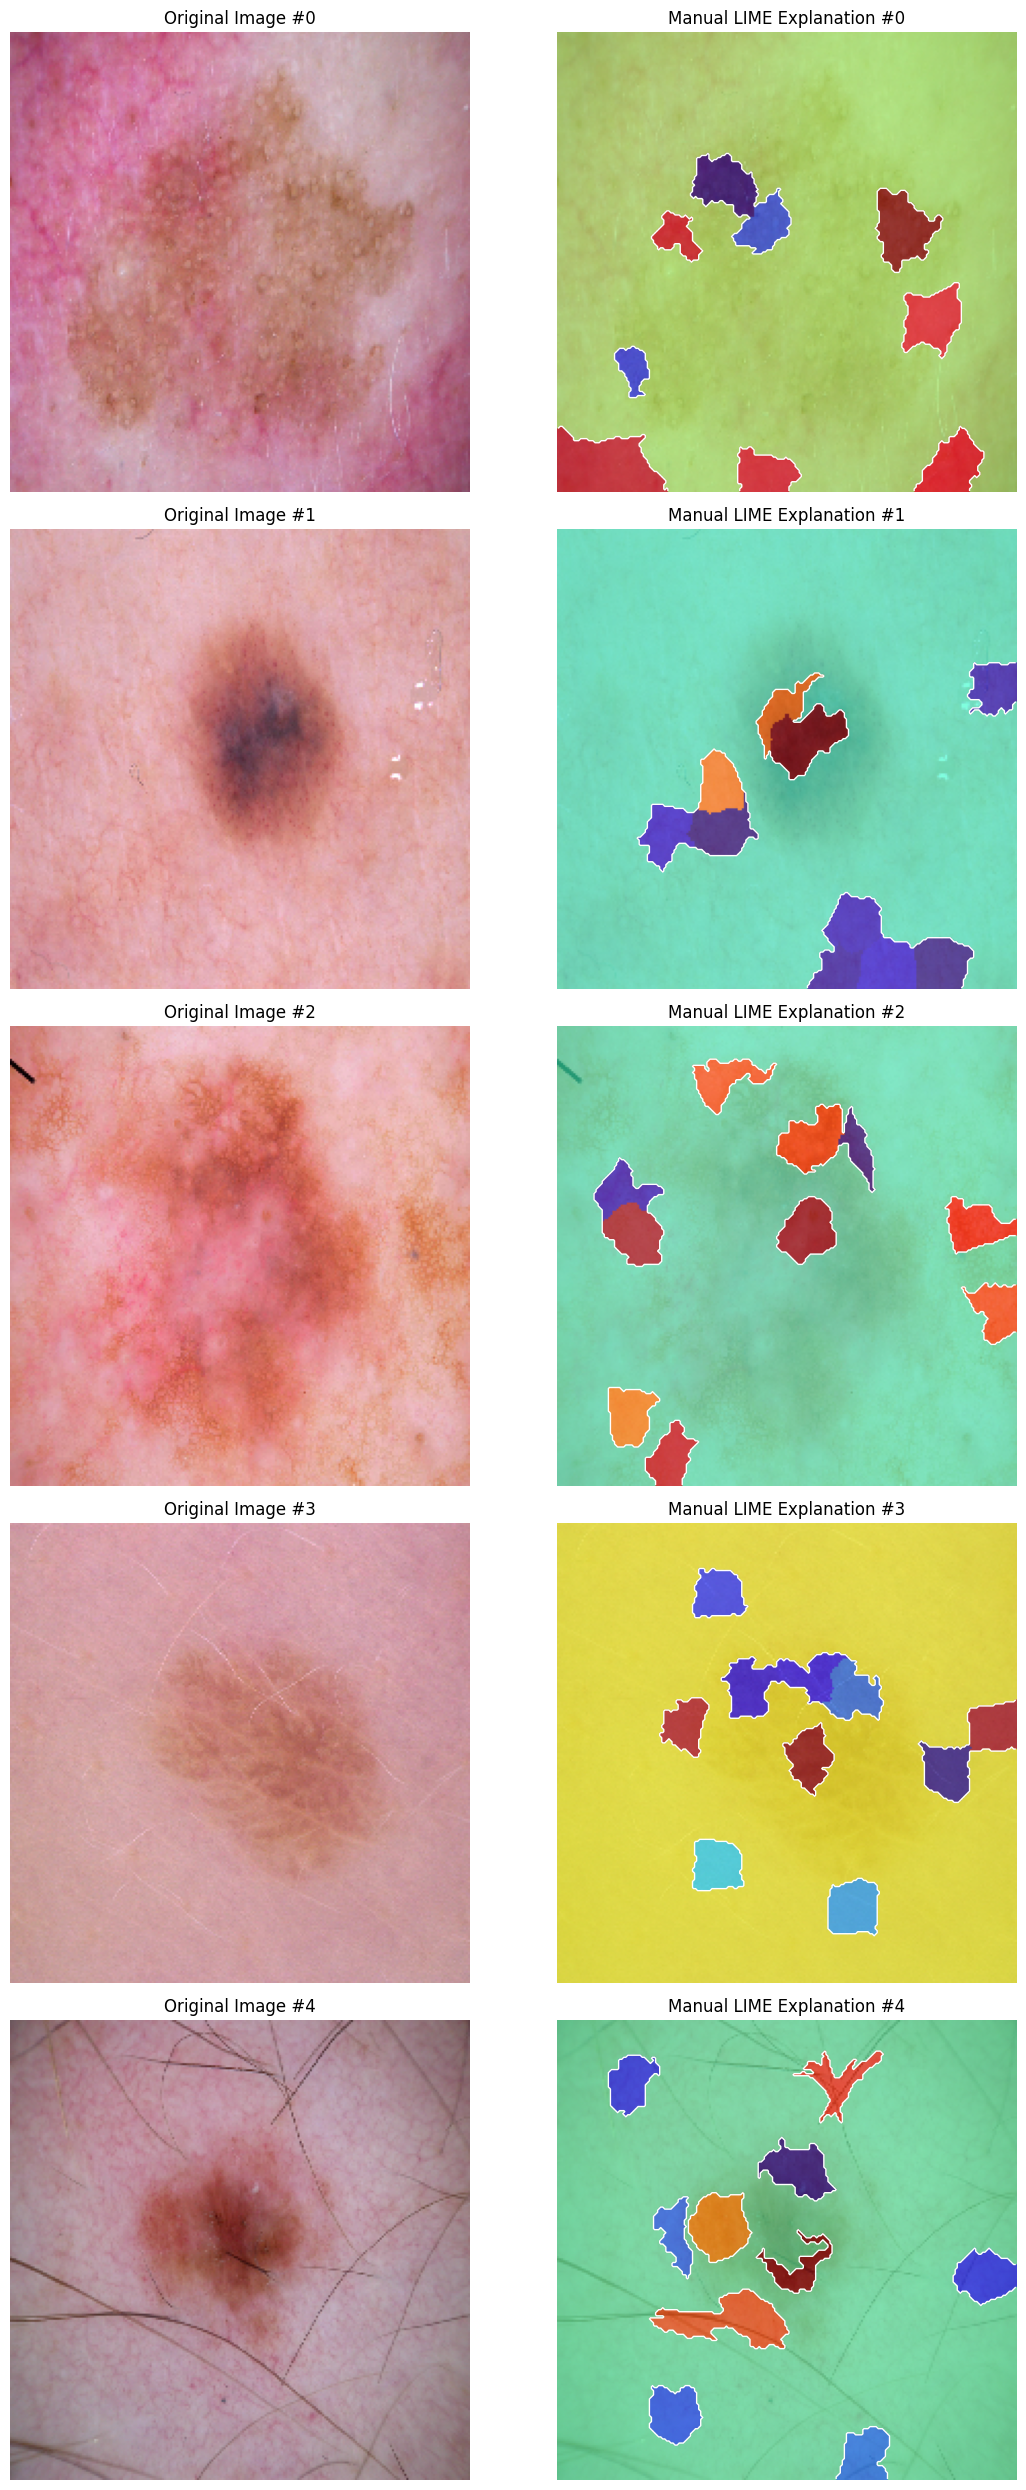

In [ ]:
from tensorflow.keras.models import load_model
from skimage.segmentation import slic
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np

# Model loading
model = load_model("efficientnet_advanced.h5")

# LIME Normalization
def normalize_for_lime(img):
    """
    Normalize the image for LIME (between 0 and 255).
    
    Args:
        img: Image to normalize.
        
    Returns:
        Normalized image.
    """
    img = np.copy(img)
    if img.max() <= 1.0 and img.min() >= -1.0:
        img = ((img + 1.0) * 127.5)
    return np.clip(img, 0, 255).astype(np.uint8)

# Image Segmentation for LIME
def segment_image(img, n_segments=100):
    """
    Segment the image into superpixels using SLIC.
    
    Args:
        img: Image to segment.
        n_segments: Number of superpixels.
        
    Returns:
        Segmented image.
    """
    return slic(img, n_segments=n_segments, compactness=10, sigma=1, start_label=0)

# Generating a LIME Dataset
def generate_lime_dataset(image, segments, model, num_samples=1000, hide_color=0):
    """
    Generate a dataset of perturbed images for LIME explanation.
    
    Args:
        image: Input image to perturb.
        segments: Segments of the image (superpixels).
        model: Model used for predictions.
        num_samples: Number of perturbed samples to generate.
        hide_color: Color used to hide superpixels during perturbation.
        
    Returns:
        A tuple of sample masks and their corresponding predictions.
    """
    n_segments = np.unique(segments).shape[0]
    samples = []
    predictions = []

    background = np.full_like(image, hide_color)

    for _ in range(num_samples):
        mask = np.random.randint(0, 2, size=n_segments)
        perturbed = np.copy(image)

        for seg_val in range(n_segments):
            if mask[seg_val] == 0:
                perturbed[segments == seg_val] = hide_color

        pred = model.predict(perturbed[np.newaxis, ...])[0]
        samples.append(mask)
        predictions.append(pred)

    return np.array(samples), np.array(predictions)

# Fit a Local Model for LIME
def fit_local_model(masks, preds, target_class):
    """
    Fit a local linear model (Ridge regression) to predict class probabilities based on perturbed images.
    
    Args:
        masks: Perturbation masks used on the image.
        preds: Model predictions for perturbed images.
        target_class: The target class to explain.
        
    Returns:
        Coefficients of the linear model.
    """
    model = Ridge(alpha=1.0)
    model.fit(masks, preds[:, target_class])
    return model.coef_

# Example - Running LIME for 5 Test Images
fig, axs = plt.subplots(5, 2, figsize=(12, 25))

for idx in range(5):
    test_image = X_test[idx]
    image_lime = normalize_for_lime(test_image)
    segments = segment_image(image_lime, n_segments=100)

    masks, preds = generate_lime_dataset(image_lime, segments, model, num_samples=1000)
    target_class = np.argmax(model.predict(test_image[np.newaxis])[0])
    coefs = fit_local_model(masks, preds, target_class)

    top_segments = np.argsort(np.abs(coefs))[-10:]
    mask = np.isin(segments, top_segments)
    heatmap = np.zeros_like(image_lime, dtype=np.float32)
    for seg_id in top_segments:
        heatmap[segments == seg_id] = coefs[seg_id]

    heatmap_vis = np.mean(heatmap, axis=-1)
    heatmap_vis = (heatmap_vis - heatmap_vis.min()) / (heatmap_vis.max() - heatmap_vis.min() + 1e-5)

    axs[idx, 0].imshow(image_lime)
    axs[idx, 0].set_title(f"Original Image #{idx}")
    axs[idx, 0].axis('off')

    axs[idx, 1].imshow(image_lime)
    axs[idx, 1].imshow(heatmap_vis, cmap='jet', alpha=0.6)
    axs[idx, 1].contour(mask, colors='white', linewidths=1.0)
    axs[idx, 1].set_title(f"Manual LIME Explanation #{idx}")
    axs[idx, 1].axis('off')

plt.tight_layout()
plt.show()


## Visualizing and Comparing SHAP and LIME

This code snippet compares and visualizes the explanations of a model’s prediction using both SHAP and LIME methods.

### Main points:

1. **SHAP Visualization**:
   - **`shap_result, shap_segments`**: Computes SHAP values using superpixels for the given test image.
   - **`normalize_for_display`**: Normalizes the test image for display.
   - **`top_k_segments_near_center`**: Selects the top 10 superpixels based on SHAP values and proximity to the image's center.
   - The SHAP results are visualized with a heatmap overlay and contours highlighting the most important superpixels.

2. **LIME Visualization**:
   - **`normalize_for_lime`**: Normalizes the test image for LIME.
   - **`segment_image`**: Segments the image into superpixels using the SLIC algorithm.
   - **`generate_lime_dataset`**: Generates perturbed versions of the image to train a local model explaining the prediction.
   - **`fit_local_model`**: Fits a Ridge regression model to the perturbed data, generating coefficients that represent the importance of each superpixel.
   - The LIME explanation is visualized with a heatmap showing the importance of superpixels based on the coefficients.

3. **Comparison Visualization**:
   - **SHAP and LIME visualizations are shown side by side** to compare the two methods. Both methods highlight the top 10 most important superpixels but may focus on different areas of the image.


1/1 [==============================] - 0s 125ms/step


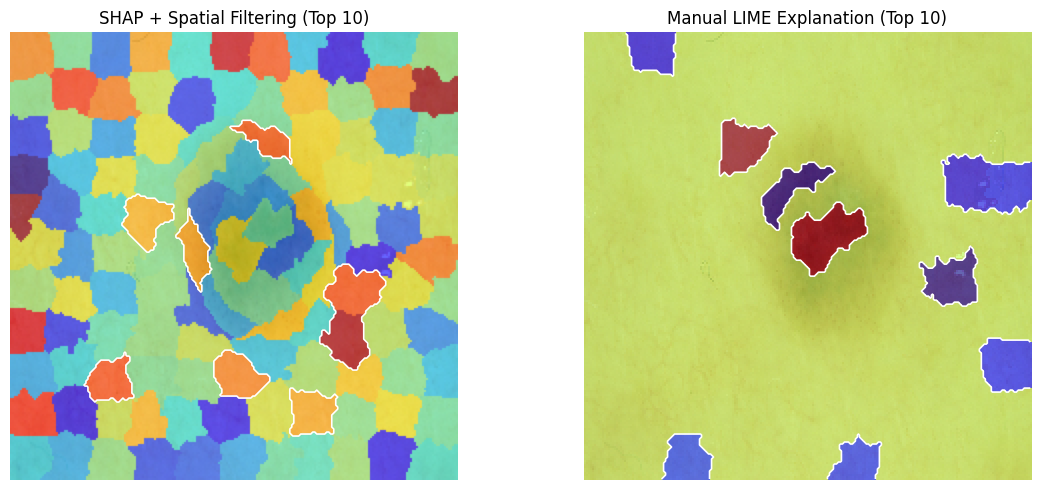

In [ ]:
# Parameters
index = 1
test_image = X_test[index]
test_label = y_test[index]
background = X_train[y_train == test_label][:50]

# SHAP:
shap_result, shap_segments = compute_shap_with_superpixels_stable(model, test_image, background)
shap_img = normalize_for_display(test_image)
shap_mask = top_k_segments_near_center(shap_result, shap_segments, k=10)

# LIME:
image_lime = normalize_for_lime(test_image)
lime_segments = segment_image(image_lime, n_segments=100)
masks_lime, preds_lime = generate_lime_dataset(image_lime, lime_segments, model, num_samples=1000)
target_class = np.argmax(model.predict(test_image[np.newaxis])[0])
lime_coefs = fit_local_model(masks_lime, preds_lime, target_class)

# Visualizing LIME heatmap
lime_heatmap = np.zeros_like(image_lime, dtype=np.float32)
top_segments_lime = np.argsort(np.abs(lime_coefs))[-10:]
for seg_id in top_segments_lime:
    lime_heatmap[lime_segments == seg_id] = lime_coefs[seg_id]
lime_heatmap_vis = np.mean(lime_heatmap, axis=-1)
lime_heatmap_vis = (lime_heatmap_vis - lime_heatmap_vis.min()) / (lime_heatmap_vis.max() - lime_heatmap_vis.min() + 1e-5)
lime_mask = np.isin(lime_segments, top_segments_lime)

# Visualizing Comparison:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(shap_img.astype(np.uint8))
axs[0].imshow(np.mean(np.abs(shap_result), axis=-1), cmap='jet', alpha=0.6)
axs[0].contour(shap_mask, colors='white', linewidths=1.2)
axs[0].set_title("SHAP + Spatial Filtering (Top 10)")
axs[0].axis('off')

axs[1].imshow(image_lime)
axs[1].imshow(lime_heatmap_vis, cmap='jet', alpha=0.6)
axs[1].contour(lime_mask, colors='white', linewidths=1.2)
axs[1].set_title("Manual LIME Explanation (Top 10)")
axs[1].axis('off')

plt.tight_layout()
plt.show()

## Faithfulness and Agreement between SHAP and LIME

### Main points:

1. **Faithfulness Test**:
   - **`faithfulness_test_superpixels`** removes the top-k superpixels based on SHAP values and observes how the model’s prediction probability changes.
   - It computes the prediction probabilities after removing superpixels, and compares the change in prediction probability with the baseline (original prediction).
   - The test helps determine if the SHAP explanation is faithful: if the removed superpixels significantly affect the prediction, then the explanation is faithful.

2. **Visualizing Faithfulness**:
   - A plot is generated showing how the prediction probability decreases as the top superpixels are removed, with a baseline line representing the original probability.
   - This helps visually assess whether the removed superpixels are critical to the model's decision.

3. **Agreement Calculation (Jaccard Index)**:
   - **`compute_agreement`** computes the Jaccard index between SHAP and LIME masks. It compares the top-k important superpixels identified by SHAP and LIME.
   - The Jaccard index measures the similarity between the two masks, with a higher score indicating better agreement.

4. **Agreement Visualization**:
   - The agreement score between SHAP and LIME (using the Jaccard index) is outputed, showing how much overlap there is in the superpixels identified by both methods.


1/1 [==============================] - 0s 126ms/step


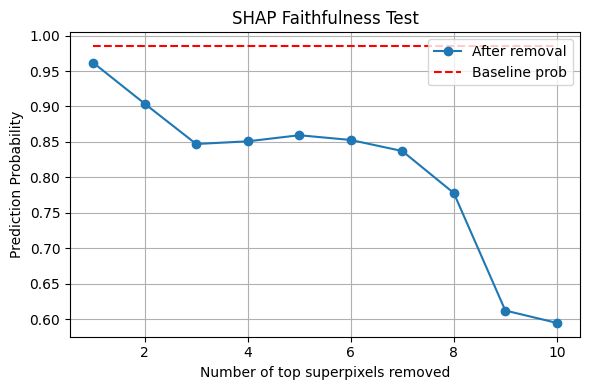

Agreement (Jaccard index) between SHAP and LIME masks: 0.03


In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

def faithfulness_test_superpixels(model, image, shap_vals, segments, target_class, steps=10):
    """
    Test the faithfulness of SHAP by removing top-k superpixels and observing the change in prediction probability.
    
    Args:
        model: The trained model.
        image: The original image.
        shap_vals: SHAP values for each pixel.
        segments: Superpixel segmentation of the image.
        target_class: The class to explain.
        steps: Number of superpixels to remove in steps.
        
    Returns:
        probs: List of probabilities after removing top-k superpixels.
        baseline: Original prediction probability.
    """
    attribution = np.mean(np.abs(shap_vals), axis=-1)
    segment_scores = {}
    for seg_id in np.unique(segments):
        segment_scores[seg_id] = np.mean(attribution[segments == seg_id])

    sorted_segments = sorted(segment_scores, key=segment_scores.get, reverse=True)
    probs = []
    baseline = model.predict(image[np.newaxis])[0][target_class]

    for k in range(1, steps + 1):
        mask = np.ones_like(attribution, dtype=bool)
        for seg_id in sorted_segments[:k]:
            mask[segments == seg_id] = False

        masked = image.copy()
        masked[~mask] = 0
        prob = model.predict(masked[np.newaxis])[0][target_class]
        probs.append(prob)

    return probs, baseline

# Running the faithfulness test
faith_probs, faith_base = faithfulness_test_superpixels(
    model, test_image, shap_result, shap_segments, target_class, steps=10
)

# Visualizing Faithfulness Test
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), faith_probs, marker='o', label="After removal")
plt.hlines(faith_base, 1, 10, colors='r', linestyles='dashed', label="Baseline prob")
plt.xlabel("Number of top superpixels removed")
plt.ylabel("Prediction Probability")
plt.title("SHAP Faithfulness Test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Agreement (Jaccard index):
def compute_agreement(mask1, mask2):
    """
    Compute the Jaccard index between two binary masks.
    
    Args:
        mask1: First binary mask.
        mask2: Second binary mask.
        
    Returns:
        Jaccard index between the two masks.
    """
    return np.sum(mask1 & mask2) / np.sum(mask1 | mask2)

# SHAP important segments (top-10)
shap_mask_agree = top_k_segments_near_center(shap_result, shap_segments, k=10)

# LIME important segments (top-10)
lime_mask_agree = np.isin(lime_segments, top_segments_lime)

# Agreement score
agreement_score = compute_agreement(shap_mask_agree, lime_mask_agree)
print(f"Agreement (Jaccard index) between SHAP and LIME masks: {agreement_score:.2f}")

### Explanation:
The SHAP Faithfulness Test evaluates the impact of removing the top-k most important superpixels (as determined by SHAP values)
on the model's prediction probability. The plot shows how the prediction probability changes as more top superpixels are removed.
If the SHAP explanation is faithful, removing important superpixels should lead to a noticeable decrease in prediction probability.
The baseline probability (represented by the dashed red line) indicates the model's prediction before any superpixels are removed.
A significant drop in the prediction probability as superpixels are removed suggests that the explanation is faithful, i.e., 
the model relies on these superpixels for its decision-making.

Agreement score (Jaccard index) is computed between SHAP and LIME masks to assess the similarity between the important 
superpixels identified by both methods. A higher agreement score indicates that SHAP and LIME identify similar superpixels 
as important for the model's prediction.
 
In this case, the Jaccard index is 0.03, which is quite low. This indicates that SHAP and LIME highlight very different 
superpixels as being important for the prediction. The low agreement could be due to the differences in the underlying 
approaches: SHAP uses a game-theoretic framework for feature attribution, while LIME fits local surrogate models based on 
perturbations of the input image. Such discrepancies are expected, and it suggests that each method provides a distinct 
perspective on the model's behavior. Further tuning and analysis of the methods could help improve alignment between the two.